<a href="https://colab.research.google.com/github/nikomadol/ResNet50-on-CIFAR-10-and-FER-2013/blob/main/MyResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Residual Networks

### Imports

In [ ]:
import numpy as np
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D
from keras.layers import BatchNormalization, Flatten, Conv2D, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

### Identity Block

When the input has the same dimension as the output.

<img src="https://raw.githubusercontent.com/priya-dwivedi/Deep-Learning/870874540a59792ad164faa92e79bfe056056241/resnet_keras/images/idblock3_kiank.png" style="width:650px;height:150px;">

**First component of main path:**
- CONV2D
  - $F_1$ filters of shape (1,1)
  - Stride of (1,1)
  - Same padding
- Batch Norm on channel
- ReLU Activation

**Second component of main path:**
- CONV2D
  - $F_2$ filters of shape (f,f)
  - Stride of (1,1)
  - Same padding
- Batch Norm on channel
- ReLU Activation

**Third component of main path:**
- CONV2D
  - $F_3$ filters of shape (1,1)
  - Stride of (1,1)
  - Same padding
- Batch Norm on channel

**Final step:**
- Add shortcut and input
- ReLU Activation

In [ ]:
def identity_block(X, filters, f):
  F1, F2, F3 = filters
  X_shortcut = X

  # First component of main path
  X = Conv2D(
      filters=F1,
      kernel_size=(1, 1),
      strides=(1, 1),
      padding='same'
  )(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  # Second component of main path
  X = Conv2D(
      filters = F2,
      kernel_size = (f, f),
      strides = (1, 1),
      padding = 'same'
  )(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  # Third component of main path
  X = Conv2D(
      filters=F3,
      kernel_size=(1, 1),
      strides=(1, 1),
      padding='same'
  )(X)
  X = BatchNormalization()(X)

  # Final step
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

### Convolutional Block

When the input and output dimensions don't match up.

<img src="https://github.com/priya-dwivedi/Deep-Learning/raw/870874540a59792ad164faa92e79bfe056056241/resnet_keras/images/convblock_kiank.png" style="width:650px;height:150px;">

**First component of main path:**
- CONV2D
  - $F_1$ filters of shape (1,1)
  - Stride of (s,s)
  - Same padding
- Batch Norm on channel
- ReLU Activation

**Second component of main path:**
- CONV2D
  - $F_2$ filters of shape (f,f)
  - Stride of (1,1)
  - Same padding
- Batch Norm on channel
- ReLU Activation

**Third component of main path:**
- CONV2D
  - $F_2$ filters of shape (1,1)
  - Stride of (1,1)
  - Same padding
- Batch Norm on channel

**Shortcut path:**
- CONV2D
  - $F_3$ filters of shape (1,1)
  - Stride of (s,s)
  - Same padding
- Batch Norm on channel

**Final step:**
- Add shortcut and input
- ReLU Activation
    

In [ ]:
def convolutional_block(X, filters, f, s):
  F1, F2, F3 = filters
  X_shortcut = X

  ##### MAIN PATH #####
  # First component of main path
  X = Conv2D(
      filters=F1,
      kernel_size=(1, 1),
      strides=(s, s),
      padding='same'
  )(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  # Second component of main path
  X = Conv2D(
      filters=F2,
      kernel_size=(f, f),
      strides=(1, 1),
      padding='same'
  )(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  # Third component of main path
  X = Conv2D(
      filters=F3,
      kernel_size=(1, 1),
      strides=(1, 1),
      padding='same'
  )(X)
  X = BatchNormalization()(X)


  ##### SHORTCUT PATH #####
  X_shortcut = Conv2D(
      filters=F3,
      kernel_size=(1, 1),
      strides=(s, s),
      padding='same'
  )(X_shortcut)
  X_shortcut = BatchNormalization()(X_shortcut)


  # Final step
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

### ResNet50 Model

<img src="https://github.com/priya-dwivedi/Deep-Learning/raw/870874540a59792ad164faa92e79bfe056056241/resnet_keras/images/resnet_kiank.png" style="width:850px;height:150px;">

- Zero padding (3,3)

- Stage 1:
  - CONV2D
    - "filters_array[0][0]" filters of shape (7,7)
    - Stride of (2,2)
    - Same padding
  - Batch Norm on channel
  - <s>Max pooling of window (3,3) and stride (2,2)</s>
  - ReLU Activation

- Stage 2:
  - Conv Block
    - 3 sets of filters "filters_array[0]"
    - filters of shape (3,3)
    - Stride of (1,1)
  - 2 * ID Block
    - 3 sets of filters "filters_array[0]"
    - filters of shape (3,3)

- Stage 3:
  - Conv Block
    - 3 sets of filters "filters_array[1]"
    - filters of shape (3,3)
    - Stride of (2,2)
  - 3 * ID Block
    - 3 sets of filters "filters_array[1]"
    - filters of shape (3,3)

- Stage 4:
  - Conv Block
    - 3 sets of filters "filters_array[2]"
    - filters of shape (3,3)
    - Stride of (2,2)
  - 5 * ID Block
    - 3 sets of filters "filters_array[2]"
    - filters of shape (3,3)

- Stage 5:
  - Conv Block
    - 3 sets of filters "filters_array[3]"
    - filters of shape (3,3)
    - Stride of (2,2)
  - 2 * ID Block
    - 3 sets of filters "filters_array[3]"
    - filters of shape (3,3)

- Global Average Pooling2D

- Flatten

- The Fully Connected (Dense) layer using softmax activation

In [ ]:
def get_model(input_shape, classes, filters):
  """
  ZEROPAD
  Stage1: CONV2D -> BATCHNORM -> RELU -> MAXPOOL
  Stage2: CONVBLOCK -> IDBLOCK*2
  Stage3: CONVBLOCK -> IDBLOCK*3
  Stage4: CONVBLOCK -> IDBLOCK*5
  Stage5: CONVBLOCK -> IDBLOCK*2
  AVGPOOL -> FLATTEN -> FC
  """
  X_input = Input(input_shape)

  # ZEROPAD
  X = ZeroPadding2D((3, 3))(X_input)

  # Stage 1
  X = Conv2D(
      filters=filters[0][0],
      kernel_size=(7, 7),
      strides=(2, 2),
      padding='same'
  )(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  # X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  # Stage 2
  X = convolutional_block(X, filters[0], f=3, s=1)
  for _ in range(2):
    X = identity_block(X, filters[0], f=3)

  # Stage 3
  X = convolutional_block(X, filters[1], f=3, s=2)
  for _ in range(3):
    X = identity_block(X, filters[1], f=3)

  # Stage 4
  X = convolutional_block(X, filters[2], f=3, s=2)
  for _ in range(5):
    X = identity_block(X, filters[2], f=3)

  # Stage 5
  X = convolutional_block(X, filters[3], f=3, s=2)
  for _ in range(2):
    X = identity_block(X, filters[3], f=3)

  # AVGPOOL
  X = GlobalAveragePooling2D()(X)

  # Output Layer
  X = Flatten()(X)
  X = Dense(units=classes, activation='softmax')(X)

  # Create model
  model = Model(inputs=X_input, outputs=X, name='ResNet50')

  return model

## Train on CIFAR-10

In [ ]:
from keras.datasets import cifar10

(X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig) = cifar10.load_data()
X_train = X_train_orig / 255
X_test = X_test_orig / 255

Y_train = Y_train_orig.flatten()
Y_train = to_categorical(Y_train)
Y_test = Y_test_orig.flatten()
Y_test = to_categorical(Y_test)

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
CLASSES = Y_train.shape[1]
WIDTH = X_train.shape[1]
HEIGHT = X_train.shape[2]
CHANNEL = X_train.shape[3]

In [ ]:
filters_array = [
    [32, 32, 128],
    [64, 64, 256],
    [128, 128, 512],
    [256, 256, 1024]
]

model = get_model((WIDTH, HEIGHT, CHANNEL), CLASSES, filters_array)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    Y_train,
    epochs=15,
    validation_split=0.2
)

Epoch 1/15
1250/1250 [==============================] - 45s 32ms/step - loss: 2.0386 - accuracy: 0.3196 - val_loss: 1.7949 - val_accuracy: 0.4178
Epoch 2/15
1250/1250 [==============================] - 39s 31ms/step - loss: 1.3883 - accuracy: 0.4995 - val_loss: 1.9463 - val_accuracy: 0.3783
Epoch 3/15
1250/1250 [==============================] - 40s 32ms/step - loss: 1.1946 - accuracy: 0.5770 - val_loss: 1.8306 - val_accuracy: 0.5440
Epoch 4/15
1250/1250 [==============================] - 40s 32ms/step - loss: 1.0297 - accuracy: 0.6383 - val_loss: 1.0538 - val_accuracy: 0.6278
Epoch 5/15
1250/1250 [==============================] - 40s 32ms/step - loss: 0.8656 - accuracy: 0.6933 - val_loss: 2.6145 - val_accuracy: 0.5626
Epoch 6/15
1250/1250 [==============================] - 41s 32ms/step - loss: 0.7580 - accuracy: 0.7349 - val_loss: 0.9270 - val_accuracy: 0.6795
Epoch 7/15
1250/1250 [==============================] - 40s 32ms/step - loss: 0.6385 - accuracy: 0.7771 - val_loss: 0.9161 -

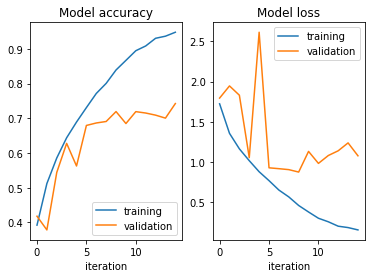

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_xlabel('iteration')
ax1.legend(['training', 'validation'], loc='lower right')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_xlabel('iteration')
ax2.legend(['training', 'validation'], loc='upper right')

In [ ]:
score = model.evaluate(X_test, Y_test)
print("Loss = " + str(score[0]))
print("Test Accuracy = " + str(score[1]))

313/313 [==============================] - 4s 11ms/step - loss: 1.1338 - accuracy: 0.7277
Loss = 1.1338281631469727
Test Accuracy = 0.7276999950408936


## Train on FER-2013

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import math

In [ ]:
# Using PyDrive to read FER-2013 csv file from Google drive
!pip install -U -q PyDrive

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=14PtUEhxalkq74AsKEqpWOKTpH77qR2Jp'
_, id = link.split('=')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('fer2013.csv')  

dataset = pd.read_csv('fer2013.csv').to_numpy()
np.random.shuffle(dataset)

In [ ]:
# Extract dataset images and labels 
dataset_images_dim = 48

dataset_images = np.empty((len(dataset), dataset_images_dim, dataset_images_dim), dtype='uint8')
dataset_labels = np.empty(len(dataset), dtype='uint8')

counter = 0
for data_row in dataset[1:]:
    emotion, img_data, _ = data_row
    img_str_array = img_data.split(" ")

    img_array = []
    for i in range(dataset_images_dim):
      image_row = []
      for j in range(dataset_images_dim):
        image_row.append(int(img_str_array[i * dataset_images_dim + j]))
      img_array.append(image_row)

    dataset_images[counter] = img_array
    dataset_labels[counter] = int(emotion)
    counter += 1
# change labels scale to one hot
dataset_labels = to_categorical(dataset_labels)
num_classes = dataset_labels.shape[1]

# reshape train data to prepare to fit into the model
dataset_images = dataset_images.reshape([dataset_images.shape[0], dataset_images.shape[1], dataset_images.shape[2], 1])

In [ ]:
# Split train and test data and labels
train_data_percent = 85
train_data_count = math.floor(len(dataset) * train_data_percent / 100)

X_train = dataset_images[:train_data_count] / 255
Y_train = dataset_labels[:train_data_count]

X_test = dataset_images[train_data_count:] / 255
Y_test = dataset_labels[train_data_count:]

In [ ]:
CLASSES = Y_train.shape[1]
WIDTH = X_train.shape[1]
HEIGHT = X_train.shape[2]
CHANNEL = X_train.shape[3]

In [ ]:
filters_array = [
    [64, 64, 256],
    [128, 128, 512],
    [256, 256, 1024],
    [512, 512, 2048]
]

model = get_model((WIDTH, HEIGHT, CHANNEL), CLASSES, filters_array)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    Y_train,
    epochs=15,
    validation_split=0.15
)

Epoch 1/15
811/811 [==============================] - 89s 104ms/step - loss: 2.0978 - accuracy: 0.2694 - val_loss: 2.5242 - val_accuracy: 0.2323
Epoch 2/15
811/811 [==============================] - 86s 106ms/step - loss: 1.5720 - accuracy: 0.4055 - val_loss: 3.1522 - val_accuracy: 0.2019
Epoch 3/15
811/811 [==============================] - 87s 107ms/step - loss: 1.4380 - accuracy: 0.4586 - val_loss: 1.9375 - val_accuracy: 0.3383
Epoch 4/15
811/811 [==============================] - 88s 108ms/step - loss: 1.2865 - accuracy: 0.5145 - val_loss: 1.7217 - val_accuracy: 0.3547
Epoch 5/15
811/811 [==============================] - 88s 108ms/step - loss: 1.2004 - accuracy: 0.5525 - val_loss: 1.7337 - val_accuracy: 0.3715
Epoch 6/15
811/811 [==============================] - 88s 108ms/step - loss: 1.1401 - accuracy: 0.5720 - val_loss: 1.4574 - val_accuracy: 0.4421
Epoch 7/15
811/811 [==============================] - 88s 108ms/step - loss: 1.1202 - accuracy: 0.5814 - val_loss: 1.4304 - val_ac

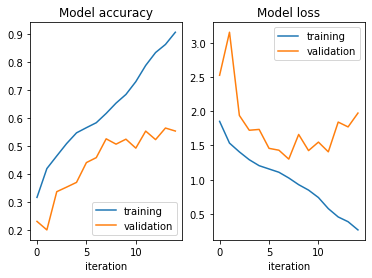

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_xlabel('iteration')
ax1.legend(['training', 'validation'], loc='lower right')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_xlabel('iteration')
ax2.legend(['training', 'validation'], loc='upper right')

In [ ]:
score = model.evaluate(X_test, Y_test)
print("Loss = " + str(score[0]))
print("Test Accuracy = " + str(score[1]))

169/169 [==============================] - 6s 29ms/step - loss: 1.9666 - accuracy: 0.5557
Loss = 1.966624140739441
Test Accuracy = 0.5557206273078918
